In [8]:
import pandas as pd
import os

folder_path = r"C:/Users/qp24297/Desktop/Final_dataset"
years = list(range(2016, 2024))

remove_gases = [
    "Sulphur oxides (SO2 and SO3) as SO2", "Carbon monoxide", "Carbon dioxide", 
    "Carbon Dioxide From Qualifying Renewable Fuel Sources", "Methane", 
    "Nitrogen - as total N", "Nitrogen oxides (NO and NO2) as NO2", "Nitrous oxide", 
    "Sulphur hexafluoride", "Hydrogen cyanide", "Fluorine and inorganic fluorine compounds - as HF", 
    "Chlorofluorocarbons (CFCs)", "Hydrochlorofluorocarbons (HCFCs)", 
    "Hydrofluorocarbons (HFCs)", "Perfluorocarbons (PFCs)"
]

def load_valid_sheet(file_path, sheet_name, year):
    preview = pd.read_excel(file_path, sheet_name=sheet_name, nrows=20, header=None)

    for i in range(5, 15): 
        candidate = preview.iloc[i].astype(str).str.lower()
        if "substance name" in candidate.values and "quantity released (kg)" in candidate.values:
            df = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=i + 1, header=None)
            df.columns = preview.iloc[i]
            df["year"] = int(year)
            return df
    print(f"⚠️ Failed to detect valid header in {sheet_name} ({year})")
    return None

all_cleaned_dfs = []

for file in os.listdir(folder_path):
    if not file.endswith(".xlsx"):
        continue

    file_path = os.path.join(folder_path, file)
    year = next((str(y) for y in years if str(y) in file), None)
    if not year:
        continue

    try:
        xls = pd.ExcelFile(file_path)
        sheet_name = next((s for s in xls.sheet_names if "substance" in s.lower() and year in s), None)
        if not sheet_name:
            print(f"⚠️ Skipped {file}: no matching 'substance' sheet for year {year}")
            continue

        df = load_valid_sheet(file_path, sheet_name, year)
        if df is None:
            continue

        # === 清洗字段 ===
        df = df[~df["SUBSTANCE NAME"].isin(remove_gases)]

        df["ROUTE NAME"] = df["ROUTE NAME"].astype(str).str.strip().str.lower()
        df = df[~df["ROUTE NAME"].isin(["air", "land"])]

        df = df[~df["QUANTITY RELEASED (kg)"].isin(["Below Reporting Threshold"])]
        df["REGULATED INDUSTRY SECTOR"] = df["REGULATED INDUSTRY SECTOR"].astype(str).str.strip().str.lower()

        all_cleaned_dfs.append(df)
        print(f"✓ Loaded: {file} | Sheet: {sheet_name} | Records: {len(df)}")

    except Exception as e:
        print(f"Error processing {file}: {e}")

# === 合并导出 ===
if all_cleaned_dfs:
    df_all = pd.concat(all_cleaned_dfs, ignore_index=True)
    print(f"\n Merge completed, total number of records：{len(df_all)}")

    output_path = r"C:/Users/qp24297/Desktop/Cleaned_Pollution_Data_2016_2023.xlsx"
    df_all.to_excel(output_path, index=False)
    print(f"save as：{output_path}")
else:
    print("Error")


✓ Loaded: 2016 Pollution Inventory dataset - version 2.xlsx | Sheet: 2016 substances | Records: 3348
✓ Loaded: 2017 Pollution Inventory Dataset.xlsx | Sheet: 2017 Substances | Records: 3287
✓ Loaded: 2018 Pollution Inventory.xlsx | Sheet: 2018 Substance | Records: 1019326
✓ Loaded: 2019 Pollution Inventory Dataset v2.xlsx | Sheet: 2019 Substances | Records: 3182
✓ Loaded: 2020 Pollution Inventory Dataset v2.xlsx | Sheet: 2020 Substances | Records: 3012
✓ Loaded: 2021 Pollution Inventory Dataset.xlsx | Sheet: 2021 Substances | Records: 3215
✓ Loaded: 2022 Pollution Inventory Dataset v2.xlsx | Sheet: 2022 Substances | Records: 3166
✓ Loaded: 2023 Pollution Inventory Dataset V2.xlsx | Sheet: 2023 Substances | Records: 2996

 Merge completed, total number of records：1041532
save as：C:/Users/qp24297/Desktop/Cleaned_Pollution_Data_2016_2023.xlsx


In [9]:
import pandas as pd

input_path = r"C:/Users/qp24297/Desktop/Cleaned_Pollution_Data_2016_2023.xlsx"
output_path = r"C:/Users/qp24297/Desktop/Fluoranthene_only.xlsx"

df = pd.read_excel(input_path)

fluor_df = df[df["SUBSTANCE NAME"].astype(str).str.strip().str.lower() == "fluoranthene"]

fluor_df.to_excel(output_path, index=False)

print(f" Fluoranthene data save as：{output_path}")


 Fluoranthene data save as：C:/Users/qp24297/Desktop/Fluoranthene_only.xlsx


In [10]:
import pandas as pd
import numpy as np

file_path = r"C:/Users/qp24297/Desktop/Fluoranthene_only.xlsx"

df = pd.read_excel(file_path)

df.columns = df.columns.str.strip().str.lower()
df["substance name"] = df["substance name"].astype(str).str.lower()

df["quantity released (kg)"] = pd.to_numeric(df["quantity released (kg)"], errors="coerce")
df["reporting threshold (kg)"] = pd.to_numeric(df["reporting threshold (kg)"], errors="coerce")
df.dropna(subset=["quantity released (kg)"], inplace=True)

qty = df["quantity released (kg)"]
threshold = df["reporting threshold (kg)"].mean()

summary = {
    "Total Quantity Released": qty.sum(),
    "Mean": qty.mean(),
    "Standard Deviation": qty.std(),
    "Min": qty.min(),
    "Max": qty.max(),
    "5th Percentile": np.percentile(qty, 5),
    "10th Percentile": np.percentile(qty, 10),
    "25th Percentile": np.percentile(qty, 25),
    "50th Percentile (Median)": np.percentile(qty, 50),
    "75th Percentile": np.percentile(qty, 75),
    "90th Percentile": np.percentile(qty, 90),
    "95th Percentile": np.percentile(qty, 95),
    "Reporting Threshold (mean)": threshold,
    "Nb of Obs": len(qty),
    "Nb Below Threshold": (qty < threshold).sum(),
    "Nb of Different Sites": df["site address"].nunique()
}

for k, v in summary.items():
    print(f"{k}: {v:.4f}" if isinstance(v, (float, int)) else f"{k}: {v}")


Total Quantity Released: 424.1954
Mean: 0.5709
Standard Deviation: 3.8406
Min: 0.0400
Max: 100.0000
5th Percentile: 0.1100
10th Percentile: 0.1100
25th Percentile: 0.1300
50th Percentile (Median): 0.1900
75th Percentile: 0.3400
90th Percentile: 0.6999
95th Percentile: 1.5990
Reporting Threshold (mean): 0.1000
Nb of Obs: 743.0000
Nb Below Threshold: 3
Nb of Different Sites: 132.0000


In [14]:
import pandas as pd

df.columns = df.columns.str.strip().str.lower()
df["ea area name"] = df["ea area name"].astype(str).str.strip().str.lower()
df["route name"] = df["route name"].astype(str).str.strip().str.lower()

region_mapping = {
    "north east": "North East",
    "cumbria and lancashire": "North West",
    "greater manchester merseyside and cheshire": "North West",
    "yorkshire": "Yorkshire and The Humber",
    "east midlands": "East Midlands",
    "lincolnshire and northamptonshire": "East Midlands",
    "west midlands": "West Midlands",
    "east anglia": "East of England",
    "hertfordshire and north london": "London",
    "kent, south london and east sussex": "South East",
    "solent and south downs": "South East",
    "thames": "South East",
    "wessex": "South West",
    "devon, cornwall and the isles of scilly": "South West",
}

df["region_grouped"] = df["ea area name"].map(region_mapping).fillna("Other")

region_counts = df["region_grouped"].value_counts(normalize=True).loc[
    lambda x: x.index != "Other"
].sort_index()

year_counts = df["year"].value_counts(normalize=True).sort_index()

def route_classifier(route):
    if "sewer" in route or "wastewater" in route or "water" in route:
        return "Wastewater"
    elif "controlled" in route or "controlled waters" in route:
        return "Controlled Waters"
    else:
        return "Other"

df["route_type"] = df["route name"].apply(route_classifier)
route_counts = df["route_type"].value_counts(normalize=True)

wastewater_share = route_counts.get("Wastewater", 0)
controlled_share = route_counts.get("Controlled Waters", 0)

print("\nShare of Samples by Route Type:")
print(f"Wastewater: {wastewater_share:.2%}")
print(f"Controlled Waters: {controlled_share:.2%}")



Share of Samples by Route Type:
Wastewater: 100.00%
Controlled Waters: 0.00%


In [15]:
import pandas as pd

df.columns = df.columns.str.strip().str.lower()
df["ea area name"] = df["ea area name"].astype(str).str.strip().str.lower()
df["route name"] = df["route name"].astype(str).str.strip().str.lower()

region_mapping = {
    "north east": "North East",
    "cumbria and lancashire": "North West",
    "greater manchester merseyside and cheshire": "North West",
    "yorkshire": "Yorkshire and The Humber",
    "east midlands": "East Midlands",
    "lincolnshire and northamptonshire": "East Midlands",
    "west midlands": "West Midlands",
    "east anglia": "East of England",
    "hertfordshire and north london": "London",
    "kent, south london and east sussex": "South East",
    "solent and south downs": "South East",
    "thames": "South East",
    "wessex": "South West",
    "devon, cornwall and the isles of scilly": "South West",
}

df["region_grouped"] = df["ea area name"].map(region_mapping).fillna("Other")

df["year"] = pd.to_numeric(df["year"], errors="coerce") 
year_share = df["year"].value_counts(normalize=True).sort_index()

df["route_type"] = df["route name"].map({
    "wastewater": "Wastewater",
    "controlled waters": "Controlled Waters"
}).fillna("Other")

route_share = df["route_type"].value_counts(normalize=True).sort_index()

print("\nShare of Samples by Region:")
region_pct = df["region_grouped"].value_counts(normalize=True).loc[
    lambda x: x.index != "Other"
].sort_index()
print(region_pct.apply(lambda x: f"{x:.2%}"))

print("\nShare of Samples by Year:")
print(year_share.apply(lambda x: f"{x:.2%}"))

print("\nShare of Samples by Route Type:")
print(route_share.apply(lambda x: f"{x:.2%}"))



Share of Samples by Region:
region_grouped
East Midlands                9.96%
East of England              9.29%
London                       7.27%
North East                   5.25%
North West                  23.15%
South East                  23.01%
South West                   8.61%
West Midlands               12.92%
Yorkshire and The Humber     0.54%
Name: proportion, dtype: object

Share of Samples by Year:
year
2016    11.98%
2017    11.71%
2018    13.06%
2019    12.79%
2020    12.92%
2021    13.73%
2022    12.11%
2023    11.71%
Name: proportion, dtype: object

Share of Samples by Route Type:
route_type
Controlled Waters    96.77%
Wastewater            3.23%
Name: proportion, dtype: object


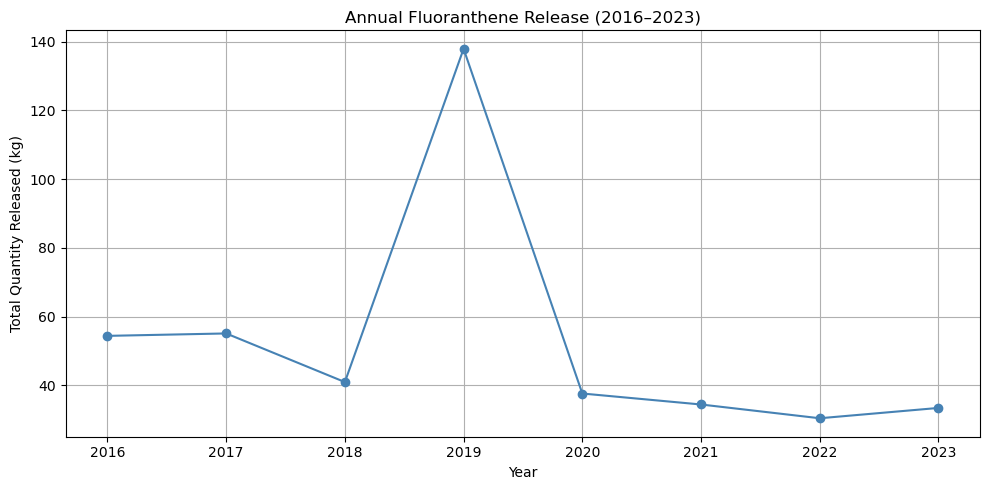

In [16]:
import matplotlib.pyplot as plt

yearly_release = df.groupby("year")["quantity released (kg)"].sum()

plt.figure(figsize=(10, 5))
plt.plot(yearly_release.index, yearly_release.values, marker='o', linestyle='-', color='steelblue')
plt.title("Annual Fluoranthene Release (2016–2023)")
plt.xlabel("Year")
plt.ylabel("Total Quantity Released (kg)")
plt.grid(True)
plt.tight_layout()
plt.show()


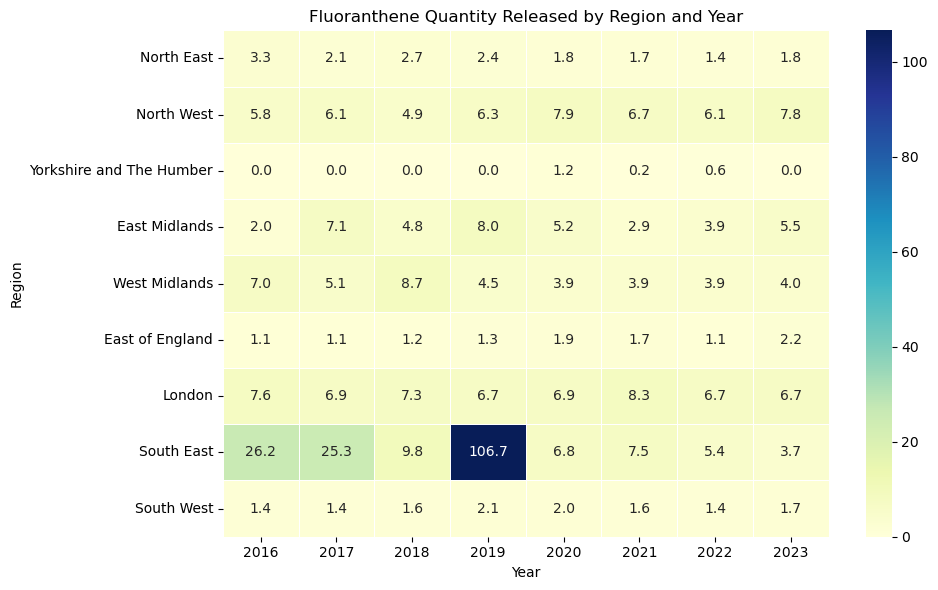

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = (
    df.groupby(["region_grouped", "year"])["quantity released (kg)"]
    .sum()
    .unstack(fill_value=0)
    .reindex([
        "North East", "North West", "Yorkshire and The Humber", "East Midlands",
        "West Midlands", "East of England", "London", "South East", "South West"
    ])
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=0.5)
plt.title("Fluoranthene Quantity Released by Region and Year")
plt.xlabel("Year")
plt.ylabel("Region")
plt.tight_layout()
plt.show()


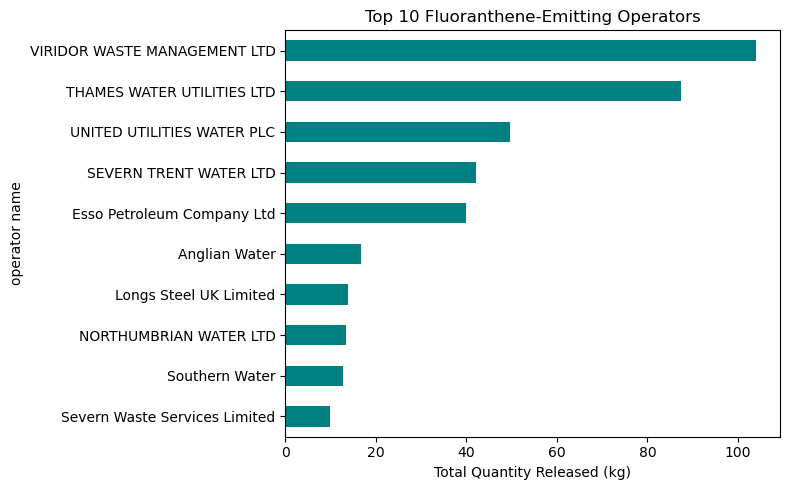

In [19]:
top_companies = (
    df.groupby("operator name")["quantity released (kg)"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

top_companies.plot(kind="barh", figsize=(8, 5), color="teal")
plt.title("Top 10 Fluoranthene-Emitting Operators")
plt.xlabel("Total Quantity Released (kg)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


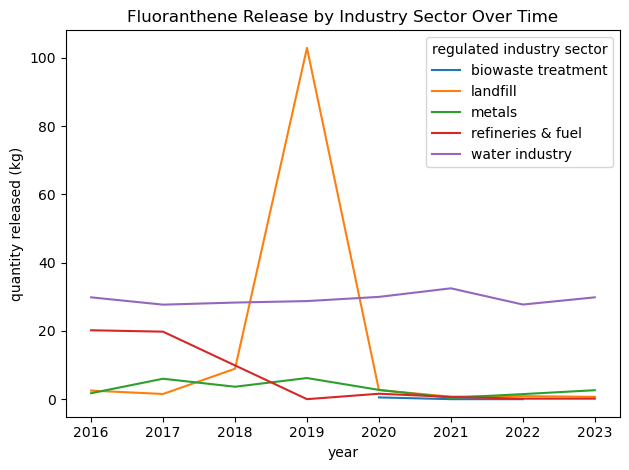

In [20]:
industry_trend = (
    df.groupby(["regulated industry sector", "year"])["quantity released (kg)"]
    .sum()
    .reset_index()
)

sns.lineplot(data=industry_trend, x="year", y="quantity released (kg)", hue="regulated industry sector")
plt.title("Fluoranthene Release by Industry Sector Over Time")
plt.tight_layout()
plt.show()
